In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [ ]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [ ]:

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving deu.txt to deu.txt


In [ ]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [6]:
deu_eng = deu_eng[:50000,:]

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['No one encouraged her.', 'Niemand ermutigte sie.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #40334 (Swift) & #370461 (Wolf)'],
       ['No one has that right.', 'Niemand hat dieses Recht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176735 (sprachensprech)'],
       ['No one has that right.', 'Dieses Recht hat niemand.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176738 (sprachensprech)']],
      dtype='<U537')

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [9]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['No one encouraged her', 'Niemand ermutigte sie',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #40334 (Swift) & #370461 (Wolf)'],
       ['No one has that right', 'Niemand hat dieses Recht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176735 (sprachensprech)'],
       ['No one has that right', 'Dieses Recht hat niemand',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176738 (sprachensprech)']],
      dtype='<U537')

In [10]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['no one encouraged her', 'niemand ermutigte sie',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #40334 (Swift) & #370461 (Wolf)'],
       ['no one has that right', 'niemand hat dieses recht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176735 (sprachensprech)'],
       ['no one has that right', 'dieses recht hat niemand',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2891740 (CK) & #6176738 (sprachensprech)']],
      dtype='<U537')

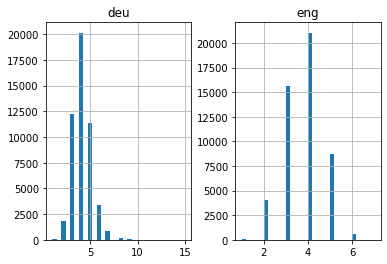

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [12]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6243


In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [17]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [18]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [19]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [20]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 3.4088
Epoch 00001: val_loss improved from inf to 2.83973, saving model to model.h1.24_jan_19
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 308s 5s/step - loss: 3.4088 - val_loss: 2.8397
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.7730
Epoch 00002: val_loss improved from 2.83973 to 2.74793, saving model to model.h1.24_jan_19
INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets
63/63 [==============================] - 316s 5s/step - loss: 2.7730 - val_loss: 2.7479
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.6320
Epoch 00003: val_loss improved from 2.74793 to 2.57358, saving mo

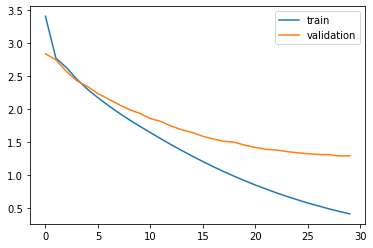

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [22]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [23]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [24]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [25]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

pd.set_option('display.max_colwidth', 200)

In [46]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
3505,he lives in luxury,he lives in tokyo
7879,it was very simple,it was really simple
5837,ill order food,ill play bread
3542,im oldfashioned,im your old
6288,i like this city,i love this city
3434,what is that thing,what is that
7670,i cant use it,i have to for
8467,he easily gets angry,he seems to
3893,tom started to laugh,tom started
6857,the lobster was good,the was
